# **Image Super Resolution: With ResNets and GANs**

# **STL 10 Dataset**
I will work with images extracted from the stl10 dataset: 
https://cs.stanford.edu/~acoates/stl10/

It contains high-resolution images of 96x96. We resize the images to 16x16 images to use as input.

I have created a custom dataset class to get the images.

In [ ]:
from torchvision.transforms.transforms import Resize
from torchvision.transforms.functional import to_pil_image
## Create a Custom Dataset for stl10 database
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2022/Final_Project/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2022/Final_Project/Results/'

# All the data will be loaded from the stl10 dataset included in pytorch torchvision
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf

import os.path
from typing import Any, Callable, Optional, Tuple, cast

from torchvision.datasets.utils import check_integrity, download_and_extract_archive, verify_str_arg
from torchvision.datasets.vision import VisionDataset

class STL10(VisionDataset):
    """`STL10 <https://cs.stanford.edu/~acoates/stl10/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``stl10_binary`` exists.
        split (string): One of {'train', 'test', 'unlabeled', 'train+unlabeled'}.
            Accordingly dataset is selected.
        folds (int, optional): One of {0-9} or None.
            For training, loads one of the 10 pre-defined folds of 1k samples for the
            standard evaluation procedure. If no value is passed, loads the 5k samples.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "stl10_binary"
    url = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
    filename = "stl10_binary.tar.gz"
    tgz_md5 = "91f7769df0f17e558f3565bffb0c7dfb"
    class_names_file = "class_names.txt"
    folds_list_file = "fold_indices.txt"
    train_list = [
        ["train_X.bin", "918c2871b30a85fa023e0c44e0bee87f"],
        ["train_y.bin", "5a34089d4802c674881badbb80307741"],
        ["unlabeled_X.bin", "5242ba1fed5e4be9e1e742405eb56ca4"],
    ]

    test_list = [["test_X.bin", "7f263ba9f9e0b06b93213547f721ac82"], ["test_y.bin", "36f9794fa4beb8a2c72628de14fa638e"]]
    splits = ("train", "train+unlabeled", "unlabeled", "test")

    def __init__(
        self,
        root: str,
        split: str = "train",
        folds: Optional[int] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.split = verify_str_arg(split, "split", self.splits)
        self.folds = self._verify_folds(folds)

        if download:
            self.download()
        elif not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        # now load the picked numpy arrays
        self.labels: Optional[np.ndarray]
        if self.split == "train":
            self.data, self.labels = self.__loadfile(self.train_list[0][0], self.train_list[1][0])
            self.labels = cast(np.ndarray, self.labels)
            self.__load_folds(folds)

        elif self.split == "train+unlabeled":
            self.data, self.labels = self.__loadfile(self.train_list[0][0], self.train_list[1][0])
            self.labels = cast(np.ndarray, self.labels)
            self.__load_folds(folds)
            unlabeled_data, _ = self.__loadfile(self.train_list[2][0])
            self.data = np.concatenate((self.data, unlabeled_data))
            self.labels = np.concatenate((self.labels, np.asarray([-1] * unlabeled_data.shape[0])))

        elif self.split == "unlabeled":
            self.data, _ = self.__loadfile(self.train_list[2][0])
            self.labels = np.asarray([-1] * self.data.shape[0])
        else:  # self.split == 'test':
            self.data, self.labels = self.__loadfile(self.test_list[0][0], self.test_list[1][0])

        class_file = os.path.join(self.root, self.base_folder, self.class_names_file)
        if os.path.isfile(class_file):
            with open(class_file) as f:
                self.classes = f.read().splitlines()

    def _verify_folds(self, folds: Optional[int]) -> Optional[int]:
        if folds is None:
            return folds
        elif isinstance(folds, int):
            if folds in range(10):
                return folds
            msg = "Value for argument folds should be in the range [0, 10), but got {}."
            raise ValueError(msg.format(folds))
        else:
            msg = "Expected type None or int for argument folds, but got type {}."
            raise ValueError(msg.format(type(folds)))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            target_img = self.transform(img)
            input_img = self.target_transform(target_img)

        return input_img, target_img


    def __len__(self) -> int:
        return self.data.shape[0]

    def __loadfile(self, data_file: str, labels_file: Optional[str] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        labels = None
        if labels_file:
            path_to_labels = os.path.join(self.root, self.base_folder, labels_file)
            with open(path_to_labels, "rb") as f:
                labels = np.fromfile(f, dtype=np.uint8) - 1  # 0-based

        path_to_data = os.path.join(self.root, self.base_folder, data_file)
        with open(path_to_data, "rb") as f:
            # read whole file in uint8 chunks
            everything = np.fromfile(f, dtype=np.uint8)
            images = np.reshape(everything, (-1, 3, 96, 96))
            images = np.transpose(images, (0, 1, 3, 2))

        return images, labels

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)
        self._check_integrity()

    def extra_repr(self) -> str:
        return "Split: {split}".format(**self.__dict__)

    def __load_folds(self, folds: Optional[int]) -> None:
        # loads one of the folds if specified
        if folds is None:
            return
        path_to_folds = os.path.join(self.root, self.base_folder, self.folds_list_file)
        with open(path_to_folds) as f:
            str_idx = f.read().splitlines()[folds]
            list_idx = np.fromstring(str_idx, dtype=np.int64, sep=" ")
            self.data = self.data[list_idx, :, :, :]
            if self.labels is not None:
                self.labels = self.labels[list_idx]

tr = tf.Compose([
        tf.ToTensor(), 
        ])
tr_resize = tf.Compose([tf.ToPILImage(),tf.Resize(16),tf.ToTensor()])

stldataset = STL10(root = data_path, split = 'train', folds = None, transform = tr, target_transform = tr_resize, download = True)
train_loader = torch.utils.data.DataLoader(dataset=stldataset,
                                           batch_size=64, 
                                           shuffle=True)


Mounted at /content/drive
Files already downloaded and verified


torch.Size([64, 3, 16, 16])
torch.Size([64, 3, 96, 96])


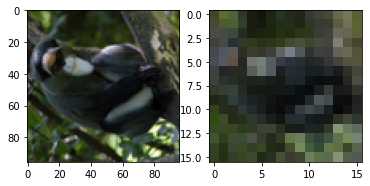

In [ ]:
input_images, target_images = next(iter(train_loader))

print(input_images.shape)
print(target_images.shape)

# Example images
images = np.fromfile(data_path+'stl10_binary/train_X.bin', dtype=np.uint8, count=96*96*3)
image = np.reshape(target_images[0], (3, 96, 96))
image = np.transpose(image, (2, 1, 0))
image_low = np.reshape(input_images[0], (3, 16, 16))
image_low = np.transpose(image_low, (2, 1, 0))
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(image_low)
plt.show()

### Model architecture definition

In [ ]:
import torch
import torch.nn as nn

#  Convolution + BatchNormnalization + ReLU block + Upsampling
class ConvBNReLUUp(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(ConvBNReLUUp, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3, padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.UpsamplingNearest2d(scale_factor=1.575)

  def forward(self,x):
    out = self.relu(self.bn(self.conv(self.pool(x))))
    return out

# Model definition with 4 ConvBNReLUUp blocks and fully-connected layer
class MyModel(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(MyModel, self).__init__()
    self.layer1 = ConvBNReLUUp(3,base_channels)
    self.layer2 = ConvBNReLUUp(base_channels,base_channels*3)
    self.layer3 = ConvBNReLUUp(base_channels*3,base_channels)
    self.layer4 = ConvBNReLUUp(base_channels,3)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out
    #return self.fc(out.view(x.shape[0],-1))

### Model training functions

In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    CNN.to(device)
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.MSELoss()
    #with torch.no_grad():
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (input_images, target_images) in enumerate(train_loader):
            # Get batch of samples and labels
            input_images = input_images.to(device)
            target_images = target_images.to(device)

            # Forward pass
            outputs = CNN(input_images)
            #print(outputs.shape)
            #print(target_images.shape)
            loss = criterion(outputs, target_images)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

### Model training

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
model = MyModel(96)

#Initialize optimizer 
learning_rate = .0001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_list = train(model, train_loader, optimizer, num_epochs=10, model_name='model.ckpt', device=device)

Epoch [1/10], Step [79/79], Loss: 0.1183
Epoch [2/10], Step [79/79], Loss: 0.0432
Epoch [3/10], Step [79/79], Loss: 0.0369
Epoch [4/10], Step [79/79], Loss: 0.0333
Epoch [5/10], Step [79/79], Loss: 0.0310
Epoch [6/10], Step [79/79], Loss: 0.0290
Epoch [7/10], Step [79/79], Loss: 0.0275
Epoch [8/10], Step [79/79], Loss: 0.0265
Epoch [9/10], Step [79/79], Loss: 0.0256
Epoch [10/10], Step [79/79], Loss: 0.0248


### Visualize low resolution and Reconstructed Images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


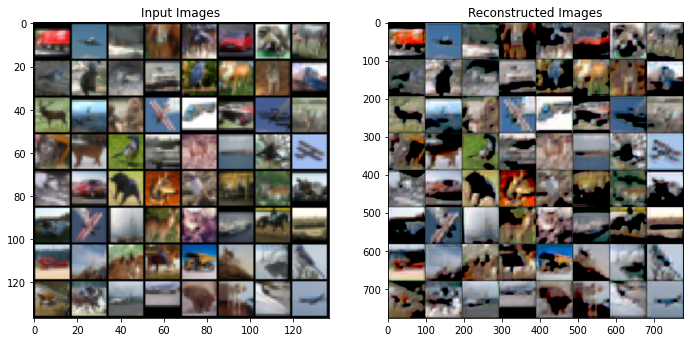

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Load trained VAE
model = MyModel(96)
model.eval() # Evaluation mode for the model
model.load_state_dict(torch.load(results_path+'/model.ckpt')) # Load model
model = model.to(device)

# Visualize reconstructions on test samples

input_images, target_images = next(iter(train_loader))
test_images = input_images.to(device)
target_images = target_images.to(device)
# Get reconstructed test images with the model
z = model(test_images)

plt.figure(figsize=(18,9))
image_grid = make_grid(test_images.cpu(),nrow=8,padding=1)
image_grid_target = make_grid(target_images.cpu(),nrow=8,padding=1) #for later
plt.subplot(1,3,1)
plt.imshow(image_grid.permute(1,2,0).detach().numpy())
plt.title('Input Images')

plt.subplot(1,3,2)
plt.title('Reconstructed Images')
image_grid = make_grid(z.cpu(),nrow=8,padding=1)
plt.imshow(image_grid.permute(1,2,0).detach().numpy())
plt.show()

### Visualize High resolution and reconstructed Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


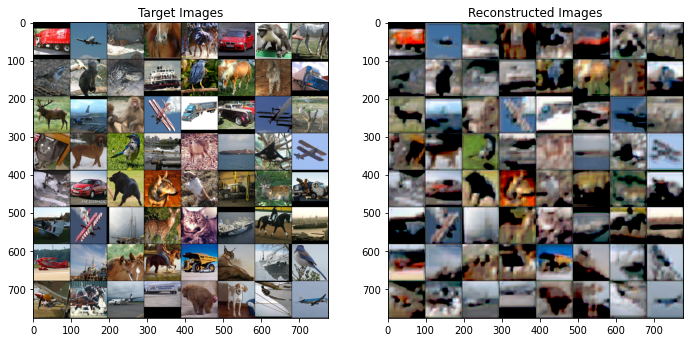

In [ ]:
plt.figure(figsize=(18,9))
plt.subplot(1,3,1)
plt.imshow(image_grid_target.permute(1,2,0).detach().numpy())
plt.title('Target Images')

plt.subplot(1,3,2)
plt.title('Reconstructed Images')
plt.imshow(image_grid.permute(1,2,0).detach().numpy())
plt.show()

### Single Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


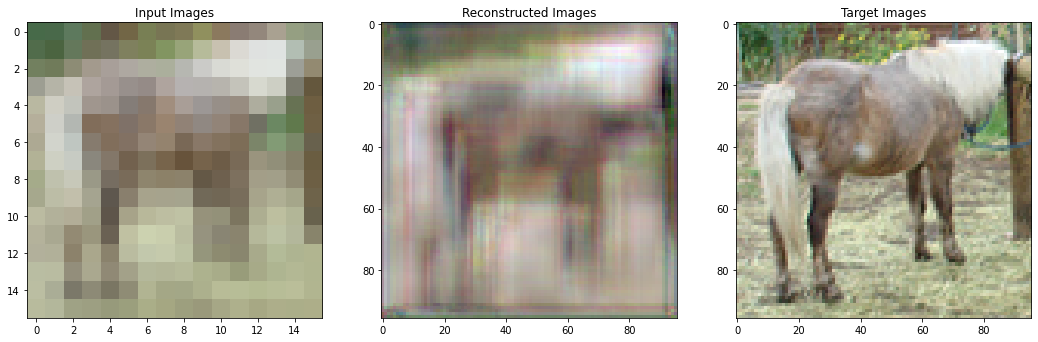

In [ ]:
import matplotlib.pyplot as plt

# Load trained VAE
model = MyModel(96)
model.eval() # Evaluation mode for the model
model.load_state_dict(torch.load(results_path+'/model.ckpt')) # Load model
model = model.to(device)

# Visualize reconstructions on test samples

input_images, target_images = next(iter(train_loader))
test_images = input_images.to(device)
target_images = target_images.to(device)
# Get reconstructed test images with the model
z = model(test_images)

plt.figure(figsize=(18,9))
plt.subplot(1,3,1)
plt.imshow(test_images[0].cpu().permute(1,2,0).detach().numpy())
plt.title('Input Images')

plt.subplot(1,3,2)
plt.title('Reconstructed Images')
plt.imshow(z[0].cpu().permute(1,2,0).detach().numpy())

plt.subplot(1,3,3)
plt.title('Target Images')
plt.imshow(target_images[0].cpu().permute(1,2,0).detach().numpy())
plt.show()

### What if we try to get better resolution than 96 with our model?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


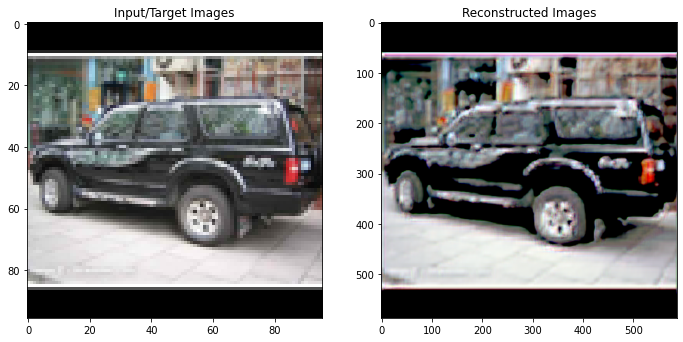

torch.Size([64, 3, 587, 587])


In [ ]:
# Load trained VAE
model = MyModel(587)
model.eval() # Evaluation mode for the model
model.load_state_dict(torch.load(results_path+'/model.ckpt')) # Load model
model = model.to(device)

# Visualize reconstructions on test samples

input_images, target_images = next(iter(train_loader))
target_images = target_images.to(device)
# Get reconstructed test images with the model
z = model(target_images)

plt.figure(figsize=(18,9))
plt.subplot(1,3,1)
plt.imshow(target_images[0].cpu().permute(1,2,0).detach().numpy())
plt.title('Input/Target Images')

plt.subplot(1,3,2)
plt.title('Reconstructed Images')
plt.imshow(z[0].cpu().permute(1,2,0).detach().numpy())
plt.show()
print(z.shape)

### Model for images of 32x32

In [ ]:
tr = tf.Compose([
        tf.ToTensor(), 
        ])
tr_resize = tf.Compose([tf.ToPILImage(),tf.Resize(32),tf.ToTensor()])

stldataset = STL10(root = data_path, split = 'train', folds = None, transform = tr, target_transform = tr_resize, download = True)
train_loader = torch.utils.data.DataLoader(dataset=stldataset,
                                           batch_size=64, 
                                           shuffle=True)

Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 96, 96])


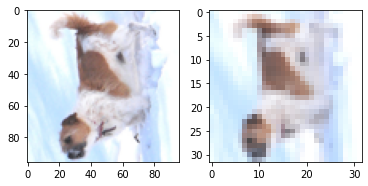

In [ ]:
input_images, target_images = next(iter(train_loader))

print(input_images.shape)
print(target_images.shape)

# Example images
images = np.fromfile(data_path+'stl10_binary/train_X.bin', dtype=np.uint8, count=96*96*3)
image = np.reshape(target_images[0], (3, 96, 96))
image = np.transpose(image, (2, 1, 0))
image_low = np.reshape(input_images[0], (3, 32, 32))
image_low = np.transpose(image_low, (2, 1, 0))
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(image_low)
plt.show()

In [ ]:
import torch
import torch.nn as nn

#  Convolution + BatchNormnalization + ReLU block + Upsampling
class ConvBNReLUUp2(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(ConvBNReLUUp2, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3, padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.UpsamplingNearest2d(scale_factor=1.3275)

  def forward(self,x):
    out = self.relu(self.bn(self.conv(self.pool(x))))
    return out

# Model definition with 4 ConvBNReLUUp blocks and fully-connected layer
class MyModel2(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(MyModel2, self).__init__()
    self.layer1 = ConvBNReLUUp2(3,base_channels)
    self.layer2 = ConvBNReLUUp2(base_channels,base_channels*3)
    self.layer3 = ConvBNReLUUp2(base_channels*3,base_channels)
    self.layer4 = ConvBNReLUUp2(base_channels,3)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    return out
    #return self.fc(out.view(x.shape[0],-1))

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
model = MyModel2(96)

#Initialize optimizer 
learning_rate = .0001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_list = train(model, train_loader, optimizer, num_epochs=10, model_name='model.ckpt', device=device)

Epoch [1/10], Step [79/79], Loss: 0.1689
Epoch [2/10], Step [79/79], Loss: 0.0680
Epoch [3/10], Step [79/79], Loss: 0.0429
Epoch [4/10], Step [79/79], Loss: 0.0337
Epoch [5/10], Step [79/79], Loss: 0.0306
Epoch [6/10], Step [79/79], Loss: 0.0284
Epoch [7/10], Step [79/79], Loss: 0.0270
Epoch [8/10], Step [79/79], Loss: 0.0256
Epoch [9/10], Step [79/79], Loss: 0.0246
Epoch [10/10], Step [79/79], Loss: 0.0235


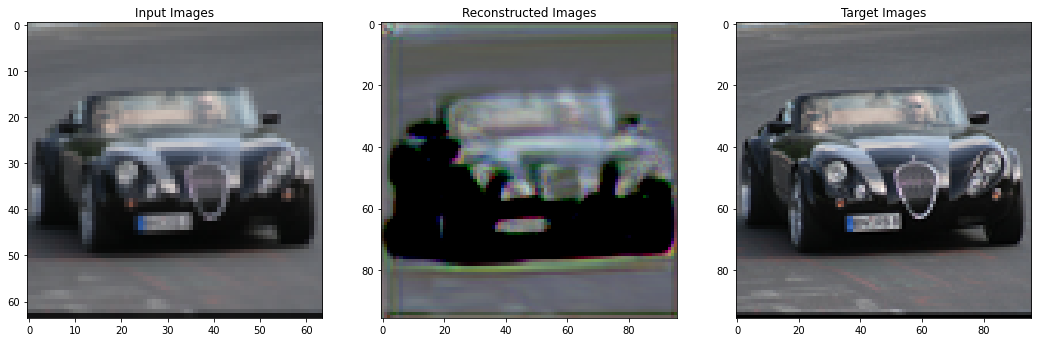

In [ ]:
import matplotlib.pyplot as plt

# Load trained VAE
model = MyModel2(96)
model.eval() # Evaluation mode for the model
model.load_state_dict(torch.load(results_path+'/model.ckpt')) # Load model
model = model.to(device)

# Visualize reconstructions on test samples

input_images, target_images = next(iter(train_loader))
test_images = input_images.to(device)
target_images = target_images.to(device)
# Get reconstructed test images with the model
z = model(test_images)

plt.figure(figsize=(18,9))
plt.subplot(1,3,1)
plt.imshow(test_images[0].cpu().permute(1,2,0).detach().numpy())
plt.title('Input Images')

plt.subplot(1,3,2)
plt.title('Reconstructed Images')
plt.imshow(z[0].cpu().permute(1,2,0).detach().numpy())

plt.subplot(1,3,3)
plt.title('Target Images')
plt.imshow(target_images[0].cpu().permute(1,2,0).detach().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


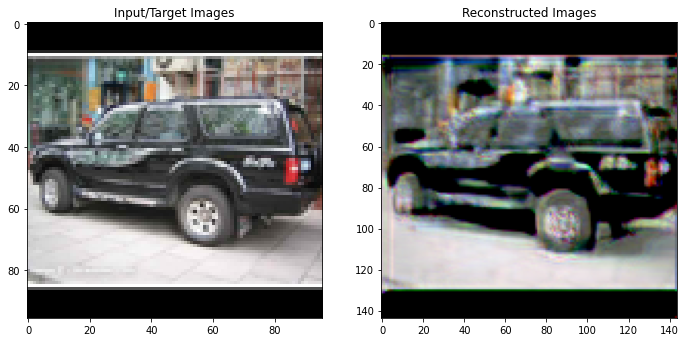

torch.Size([64, 3, 144, 144])


In [ ]:
# Load trained VAE
model = MyModel2(587)
model.eval() # Evaluation mode for the model
model.load_state_dict(torch.load(results_path+'/model.ckpt')) # Load model
model = model.to(device)

# Visualize reconstructions on test samples

input_images, target_images = next(iter(train_loader))
target_images = target_images.to(device)
# Get reconstructed test images with the model
z = model(target_images)

plt.figure(figsize=(18,9))
plt.subplot(1,3,1)
plt.imshow(target_images[0].cpu().permute(1,2,0).detach().numpy())
plt.title('Input/Target Images')

plt.subplot(1,3,2)
plt.title('Reconstructed Images')
plt.imshow(z[0].cpu().permute(1,2,0).detach().numpy())
plt.show()
print(z.shape)